In [5]:
# Imports
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Custom import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from scipy.optimize import minimize
from datetime import datetime, timedelta
import datetime as dt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import style
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

style.use('ggplot')

# Create an instance
qb = QuantBook()

ModuleNotFoundError: No module named 'System'

In [2]:
BTC = qb.AddCrypto("BTCUSD")
LTC = qb.AddCrypto("LTCUSD")
df = qb.History(qb.Securities.Keys, datetime(2018, 1, 1, 0, 0), datetime(2018, 12, 31, 0, 0) , Resolution.Daily)

In [3]:
# Set date ranges for matplotlib
dr = df.loc['BTCUSD'].reset_index()
dr_max = dr['time'].max()
dr_min = dr['time'].min()

In [4]:

btc = pd.DataFrame(df.loc["BTCUSD"]["close"])
ltc = pd.DataFrame(df.loc["LTCUSD"]["close"])


securities = pd.concat([btc,ltc],axis=1)

securities.columns = ['BTC','LTC']
securities =  securities.dropna()
securities.head()

,BTC,LTC
time,,
2018-01-02,13480.01,225.22
2018-01-03,14781.51,253.31
2018-01-04,15098.14,244.99
2018-01-05,15144.99,238.91
2018-01-06,16960.01,246.23


In [5]:
daily_return = securities.pct_change()
daily_return.index.names =['Date']
daily_return.head()
short_rolling = daily_return.rolling(window=20).mean()
short_rolling.tail(5)

,BTC,LTC
Date,,
2018-12-27,0.006072,0.009044
2018-12-28,0.003961,0.007276
2018-12-29,0.007847,0.016564
2018-12-30,0.003846,0.011833
2018-12-31,0.006897,0.015946


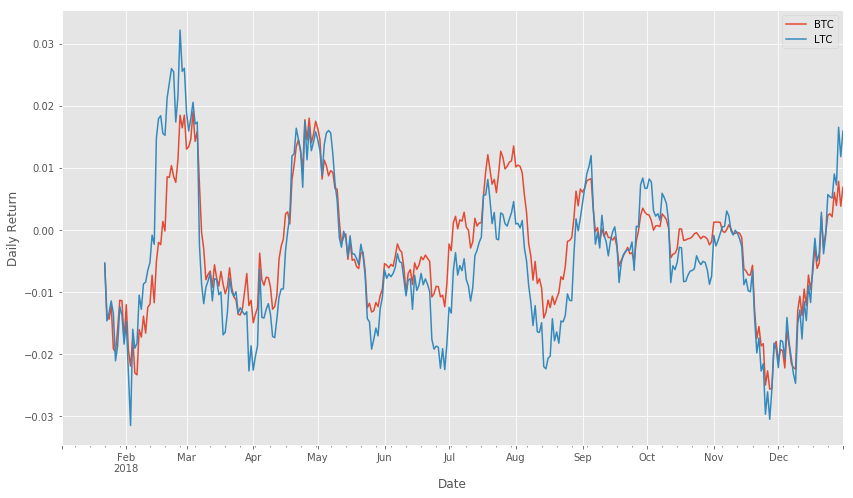

In [6]:
short_rolling.plot(figsize=(14,8))
plt.ylabel('Daily Return')
plt.xlim(dr_min,dr_max)
plt.legend()
plt.show()

In [7]:
results = smf.ols('BTC ~ LTC', data=daily_return).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     913.0
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          6.94e-101
Time:                        03:18:52   Log-Likelihood:                 852.87
No. Observations:                 363   AIC:                            -1702.
Df Residuals:                     361   BIC:                            -1694.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.567e-05      0.001     -0.037      0.9

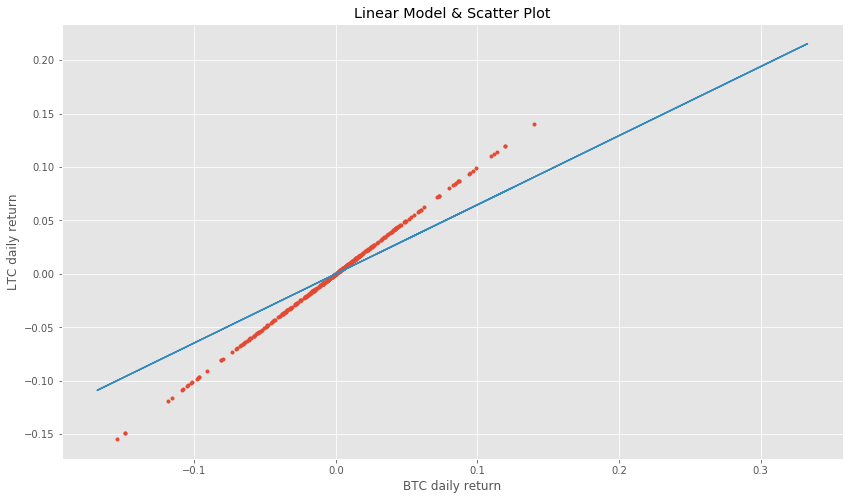

In [8]:
plt.figure(figsize=(14,8))
plt.xlabel('BTC daily return')
plt.ylabel('LTC daily return')
plt.title('Linear Model & Scatter Plot')
plt.plot(daily_return['BTC'], daily_return['BTC'], '.', daily_return['LTC'], results.predict(daily_return['LTC']), '-');

In [9]:
results.params

Intercept   -0.000046
LTC          0.646554
dtype: float64

In [10]:
alpha = results.params[0]
beta = results.params[1]
print('alpha:' + str(alpha))
print('beta:' + str(beta))

alpha:-4.566777042840759e-05
beta:0.6465542683877656


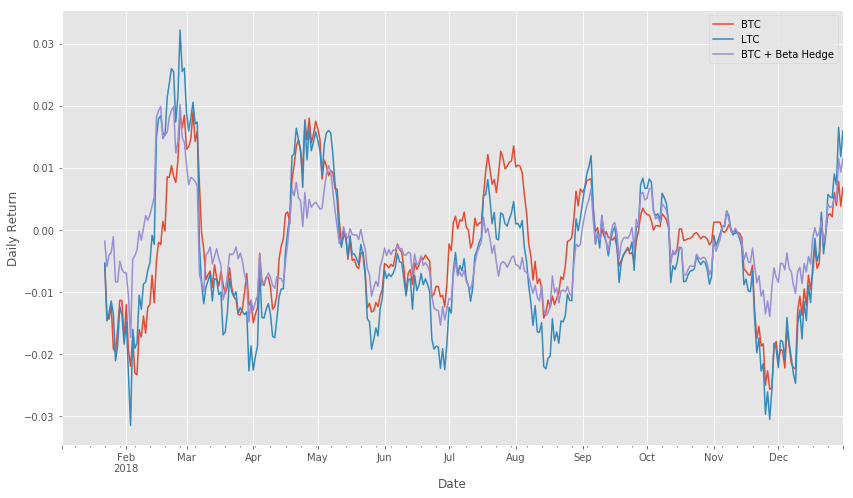

In [11]:

#bulding portfolio with beta hedging
#Alpha = actual return - [Beta(rm-rf)+rf]
#In this case the risk free rate is 0, so Alpha is just the intercet in the
#linear model
#Beta is the hedge ratio, so the hedge is only added to the BTC return, thus we get the pure Alpha



portfolio = -1*beta*daily_return['BTC'] + daily_return['LTC']
portfolio.name = "BTC + Beta Hedge"
portfolio_mvg = portfolio.rolling(window=20).mean()
daily_return['BTC'].rolling(window=20).mean().plot(figsize=(14,8)) 
daily_return['LTC'].rolling(window=20).mean().plot(figsize=(14,8))
portfolio_mvg.plot(figsize=(14,8))
plt.ylabel("Daily Return")
plt.xlim(dr_min,dr_max)
plt.legend()
plt.show()

In [12]:
daily_return['BTC + Beta Hedge'] = portfolio
daily_return.head()

,BTC,LTC,BTC + Beta Hedge
Date,,,
2018-01-02,NaN,NaN,NaN
2018-01-03,0.096550,0.124722,0.062297
2018-01-04,0.021421,-0.032845,-0.046695
2018-01-05,0.003103,-0.024817,-0.026824
2018-01-06,0.119843,0.030639,-0.046846


In [13]:
#use cumprod() function to return the cumulative multiplication results.
cum_daily_return = (1 + daily_return).cumprod()
cum_daily_return.head()

,BTC,LTC,BTC + Beta Hedge
Date,,,
2018-01-02,NaN,NaN,NaN
2018-01-03,1.096550,1.124722,1.062297
2018-01-04,1.120039,1.087781,1.012694
2018-01-05,1.123515,1.060785,0.985530
2018-01-06,1.258160,1.093287,0.939362


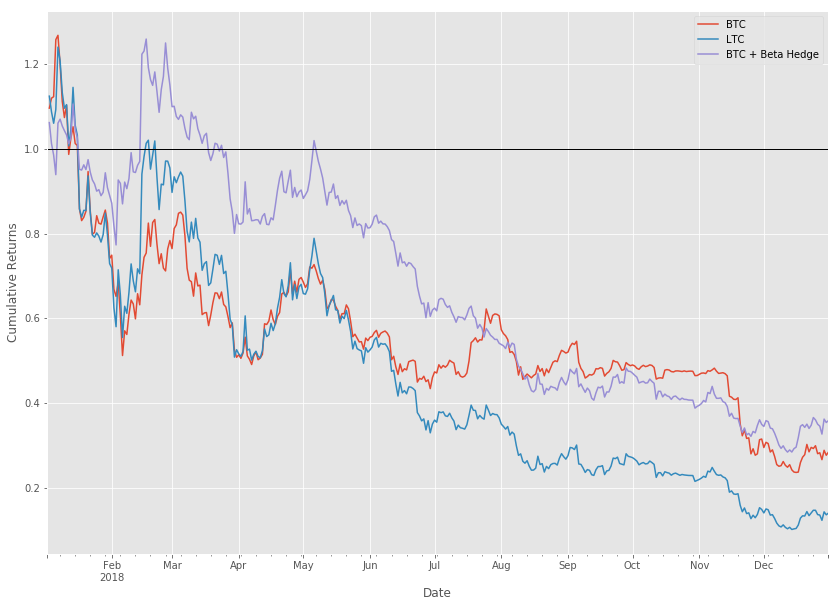

In [14]:
cum_daily_return.plot(grid = True, figsize=(14,10)).axhline(y = 1, color = "black", lw = 1)
plt.ylabel("Cumulative Returns")
plt.xlim(dr_min,dr_max)
plt.legend()
plt.show()